In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The computation of the Poisson pressure equation is the most computationally intensive part of the pressure-corrected Navier-Stokes algorithm. Take the following Poisson equation as an example:

$$\frac{\partial^2{u}}{\partial{x^2}}+\frac{\partial^2{u}}{\partial{y^2}}=2\left[x(x-1)+y(y-1)\right]$$

We will take the boundary condition to be u = 0. The analytical solution to this equation $u(x,y)=xy(x-1)(y-1)$, which we will use for reference. First, define a function to compute and return the maximum error between the analytical solution and the computed solution.

In [2]:
def error(u, u_a):
    err = np.abs(u-u_a).max()
    return err

Let's compute and visualize the analytical solution, along with an initial guess.

In [3]:
L = 1.
nx = 101
ny = 101
dx = L/(nx-1)
dy = L/(ny-1)
x = np.linspace(0, L, nx)
y = np.linspace(0, L, ny)
u_a = np.empty((ny, nx))
f = np.empty((ny, nx))

# Source term
for i in range(nx):
    for j in range(ny):
        f[j, i] = 2 * (x[i]*(x[i]-1) + y[j]*(y[j]-1))
        
# Analytic solution
for i in range(nx):
    for j in range(ny):
        u_a[j, i] = x[i]*y[j]*(x[i]-1)*(y[j]-1)

# Initial guess
u0 = np.ones((ny, nx)) / 20
u0[0,:] = 0
u0[-1,:] = 0
u0[:,0] = 0
u0[:,-1] = 0

Text(0.5, 0, 'u')

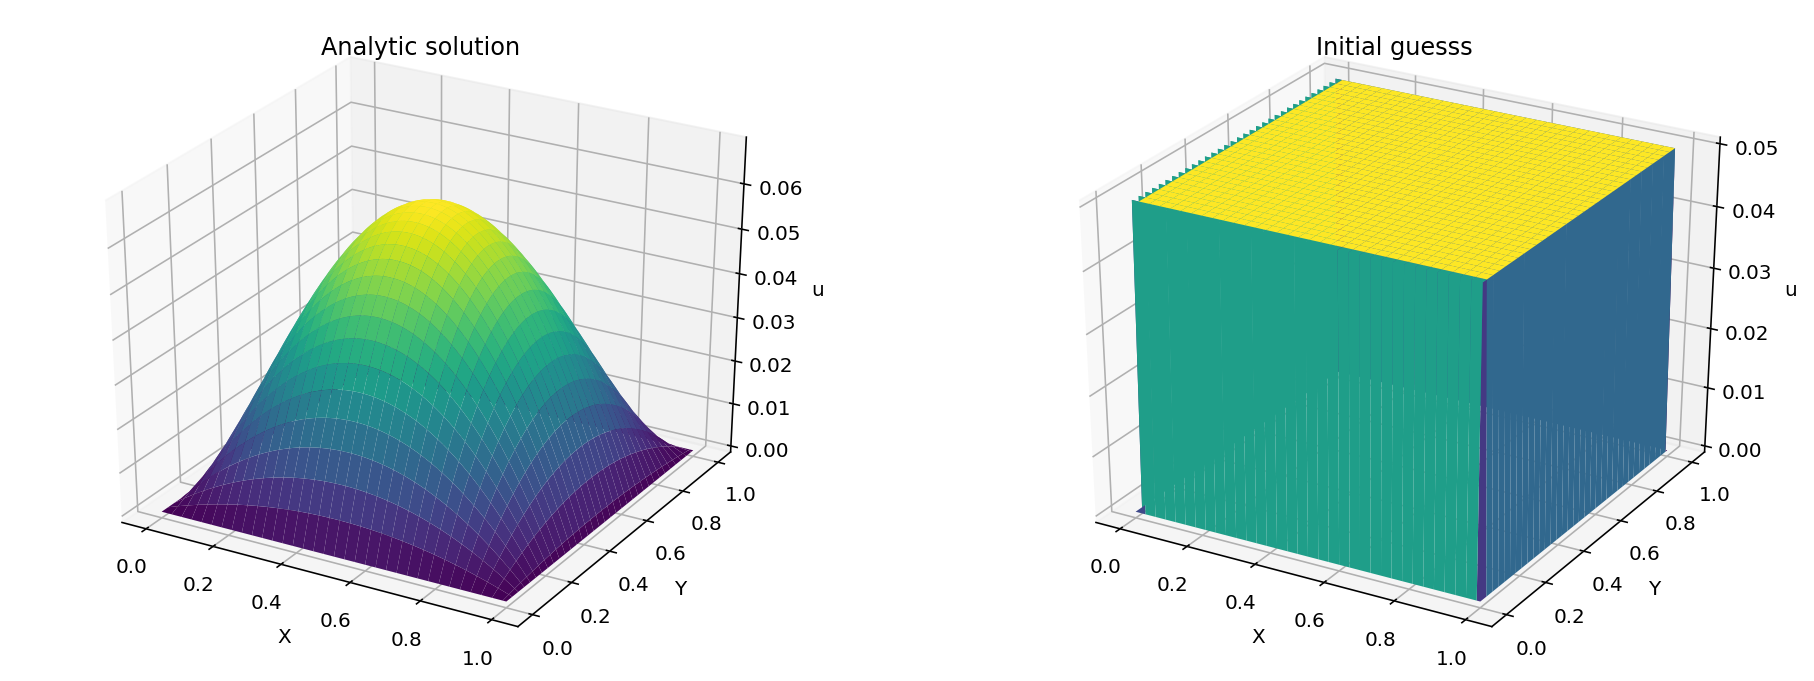

In [4]:
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, u_a, cmap=cm.viridis)
ax.set_title('Analytic solution')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('u')
ax.set_zlim(top=(u_a.max()*1.1))
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, u0, cmap=cm.viridis)
ax.set_title('Initial guesss')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('u')

In our current scheme, the discretization of the Poisson equation is:

$$u_{i+1,j}+u_{i-1,j}+u_{i,j+1}+u_{i,j-1}-4u_{i,j}=f_{i,j}h^2$$

Writing this as a recurrence relationship:

$$u_{i,j} = u_{i,j} + \frac{\omega}{4}\left(u_{i+1,j}+u_{i-1,j}+u_{i,j+1}+u_{i,j-1}-4u_{i,j}-f_{i,j}h^2\right)$$

Or, equivalently:

$$u_{i,j} = (1-\omega)u_{i,j} + \frac{\omega}{4}\left(u_{i+1,j}+u_{i-1,j}+u_{i,j+1}+u_{i,j-1}-f_{i,j}h^2\right)$$

## Jacobi iteration

If we let $\omega = 1$, we have:

$$u_{i,j}^{m+1} = \frac{1}{4}\left(u_{i+1,j}^{m}+u_{i-1,j}^{m}+u_{i,j+1}^{m}+u_{i,j-1}^{m}-f_{i,j}h^2\right)$$

In [47]:
def jacobi(nx, ny, dx, dy, u_a, u0, f):
    u = np.copy(u0)
    max_iter = 1000
    max_error = 1e-2
    i = 0
    err = 1
    start = time.time()
    err_array = []
    while (err > max_error) & (i < max_iter):
        un = np.copy(u)
        u[1:-1,1:-1] = 0.25 * (un[1:-1,2:] + un[1:-1,:-2] + un[2:,1:-1] + un[:-2,1:-1] - f[1:-1,1:-1] * dx**2)
        u[0,:] = 0
        u[-1,:] = 0
        u[:,0] = 0
        u[:,-1] = 0
        err = error(u, u_a)
        err_array.append(err)
        i += 1
    finish = time.time()
    print(f'Final error: {err:.4f}, iterations: {i}, total time: {finish-start:.2f} seconds')
    plt.plot(err_array)
    plt.xlabel('iteration')
    plt.ylabel('max error')

Final error: 0.0100, iterations: 664, total time: 0.08 seconds


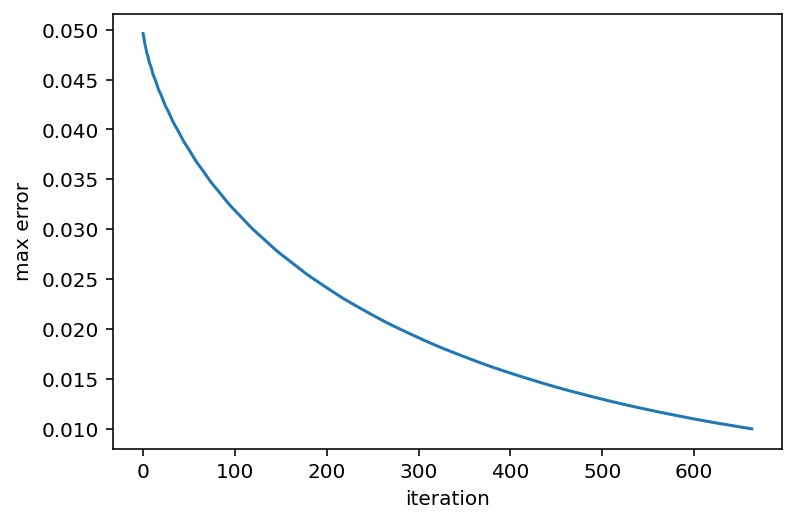

In [48]:
jacobi(nx, ny, dx, dy, u_a, u0, f)

That's a pretty efficient computation, with less than 1 millisecond per loop. Now, using two embedded for loops will be less efficient, and is performed below:

## Gauss-Seidel

In [7]:
def gauss_seidel(nx, ny, dx, dy, u_a, u0, f):
    u = np.copy(u0)
    max_iter = 1000
    max_error = 1e-2
    i = 0
    err = 1
    start = time.time()
    err_array = []
    while (err > max_error) & (i < max_iter):
        un = np.copy(u)
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                u[j,i] = 0.25 * (un[j,i+1] + un[j,i-1] + un[j+1,i] + un[j-1,i] - f[i,j] * dx**2)
        u[0,:] = 0
        u[-1,:] = 0
        u[:,0] = 0
        u[:,-1] = 0
        err = error(u, u_a)
        err_array.append(err)
        i += 1
    finish = time.time()
    print(f'Final error: {err:.4f}, iterations: {i}, total time: {finish-start:.2f} seconds')
    plt.plot(err_array)
    plt.xlabel('iteration')
    plt.ylabel('max error')

Final error: 0.0100, iterations: 100, total time: 10.02 seconds


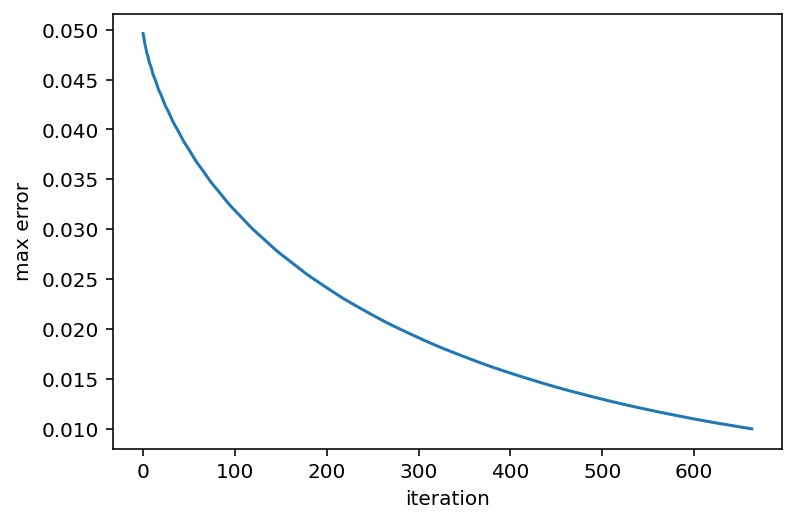

In [8]:
gauss_seidel(nx, ny, dx, dy, u_a, u0, f)

Very interesting results. Same computation in the end, but the method results in a massive difference in the computation time.

We'll now try successive order relaxation (SOR), which is the same equation, but with $1 \leq \omega \leq 2$.

## Successive order relaxation

$$u_{i,j}^{m+1} = (1-\omega)u_{i,j}^{m} + \frac{\omega}{4}\left(u_{i+1,j}^{m}+u_{i-1,j}^{m+1}+u_{i,j+1}^{m}+u_{i,j-1}^{m+1}-f_{i,j}h^2\right)$$

In [84]:
def sor(nx, ny, dx, dy, u_a, u0, f):
    u = np.copy(u0)
    max_iter = 1000
    max_error = 1e-2
    idx = 1
    err = 1
    w = 1.93
    start = time.time()
    err_array = []
    while (err > max_error) & (idx < max_iter):
        for j in range(1,nx-1):
            for i in range(1,ny-1):
                u[i,j] = (1-w)*u[i,j] + 0.25*w*(u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - f[i,j]*dx**2)
        if idx % 50 == 0:
            print(f'Iteration: {idx}')
        err = error(u, u_a)
        err_array.append(err)
        idx += 1
    finish = time.time()
    print(f'Final error: {err:.4f}, iterations: {idx}, total time: {finish-start:.2f} seconds')
    plt.plot(err_array)
    plt.xlabel('iteration')
    plt.ylabel('max error')

Iteration: 50
Final error: 0.0099, iterations: 52, total time: 1.00 seconds


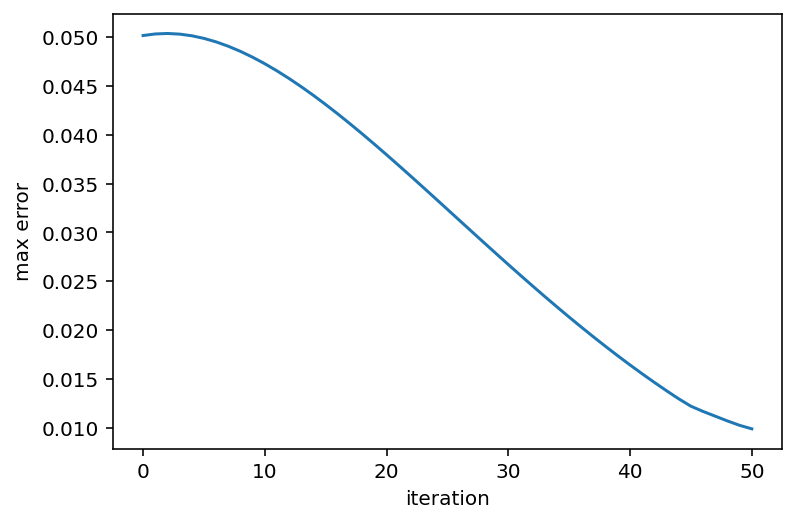

In [85]:
sor(nx, ny, dx, dy, u_a, u0, f)

# Red-Black SOR Iteration

This is a parallelization of the SOR method.

In [101]:
def red_black_sor(nx, ny, dx, dy, u_a, u0, f):
    u_n = np.copy(u0)
    err_array = []
    max_iter = 1000
    max_err = 1e-2
    # Step 1: create *integer* array the same size as u 
    x = np.zeros_like(u0,dtype=np.int)
    
    # Step 2: populate all non-boundary cells with running numbers from 1 to (n-2)^2
    x[1:-1,1:-1] = np.arange(1,(nx-2)**2+1).reshape(nx-2,nx-2)
    
    # Step 3: get indices of even (red) and odd (black) points
    ir, jr = np.where((x>0) & (x%2 == 0)) # indices of red pts = indices of even numbers
    ib, jb = np.where((x>0) & (x%2 == 1)) # indices of black pts = indices of odd numbers
    
    idx = 0
    start = time.time()
    while True:
        idx += 1

        # Red point update
        u_n[ir,jr] = 0.25*(u_n[ir+1,jr] + u_n[ir-1,jr] + u_n[ir,jr+1] + u_n[ir,jr-1] - f[ir,jr]*dx**2)
        
        # Black point update
        u_n[ib,jb] = 0.25*(u_n[ib+1,jb] + u_n[ib-1,jb] + u_n[ib,jb+1] + u_n[ib,jb-1] - f[ib,jb]*dx**2)
                
        err = error(u_n, u_a)
        err_array.append(err)

        if err < max_err:
            break

        if idx > max_iter:
            break 
    finish = time.time()
    print(f'Final error: {err:.4f}, iterations: {idx}, total time: {finish-start:.2f} seconds')
    plt.plot(err_array)
    plt.xlabel('iteration')
    plt.ylabel('max error')

Final error: 0.0100, iterations: 332, total time: 0.13 seconds


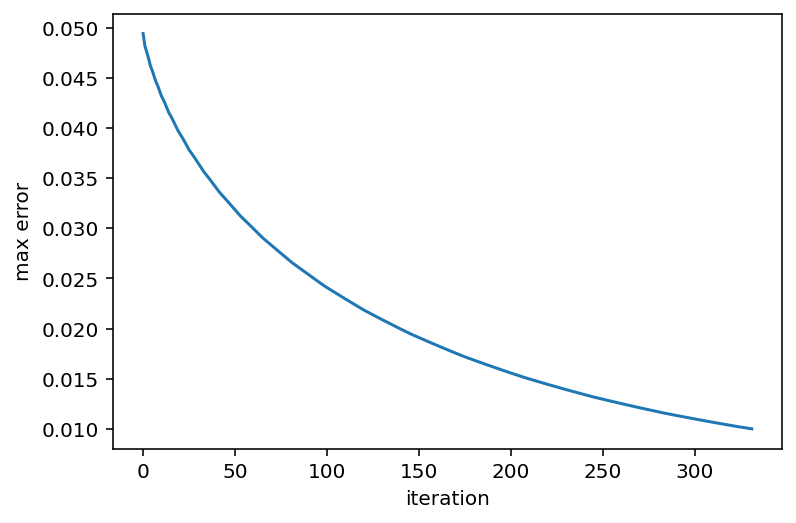

In [102]:
red_black_sor(nx, ny, dx, dy, u_a, u0, f)